# Authors

This jupyter notebook was written by Renato L. de F. Cunha and Kimilee Gile as part of the capstone activity for the deep learning track, foundation level.

# Purpose

This jupyter notebook documents the process of creating a fully-connected (dense) neural network for handwritten digit classification.

To instantiate the proverbial "a picture is worth a thousand words", what we want is a neural network that does this:

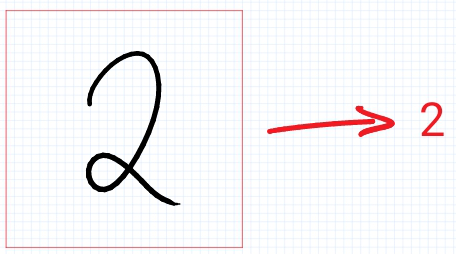

In other words, the neural network receives a 28x28 image of a handwritten digit and it should output a symbol that represents that handwritten digit. In this case, the number two inside the box should be output as a `2` by the neural network.

# Framework

We're going to be using Keras to solve this problem, so we'd better import it into our namespace.

In [1]:
import keras
from keras import backend as K

Using TensorFlow backend.


## Quality of life libraries

It turns out Keras can't do much by itself. So we're going to import a library for handling $n$-dimensional arrays (`numpy`), and another for plotting (`matplotlib`). We're also adding some magic to support inline graphs! \o/

In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

plt.style.use('bmh')  # Did you read "Bayesian Methods for Hackers?"

%matplotlib inline

# Dataset

It just so happens that the dataset we're using is quite standard and is included in every high-level deep learning framework (it's named "MNIST", in case you're wondering). We will be using the one from Keras, *but* the Keras dataset only goes so far as downloading the raw matrices, so we're going to go ahead and add some helper code to massage the data into a format Keras can actually do something with.

In [3]:
from keras.datasets import mnist

def load_data(num_classes=10):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    _, img_rows, img_cols = x_train.shape

    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_data()

Great! So the matrices `x_train`, `y_train`, `x_test`, and `y_test` hold our training (`x_train`, `y_train`) and test (`x_test`, and `y_test`) sets!

We should also go ahead and print an example digit just to make sure data was loaded correctly:

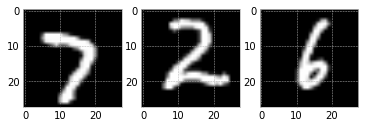

In [4]:
fig, ax = plt.subplots(1, 3)
for i in range(3):
    ax[i].imshow(x_train[np.random.randint(0, x_train.shape[0] - 1)],
                 cmap='gray', interpolation='bilinear')

# Evaluation

Since this is a multi-task classification problem with a *balanced* dataset, there is no harm in using accuracy as an evaluation metric.
Therefore, we will evaluate our model as

In [5]:
def evaluate(model, x_test=x_test, y_test=y_test):
    return model.evaluate(x_test, y_test)

Another thing that will be *really* helpful for us will be visualizing the performance of the model as training proceeds. Keras already provides us with a history callback once a model is trained. So, we can easily plot the results with:

In [6]:
def plot(history, title=None):
    def plot_helper(history, key):
        fig = plt.figure()
        plt.plot(history[key], label='Training %s' % key)
        if 'val_' + key in history:
            plt.plot(history['val_' + key],
                     label='Validation %s' % key)
        plt.title('Model %s over "time"' % key \
                  if not title else title % key)
        plt.ylabel(key.capitalize())
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()
        fig.tight_layout()
        return fig

    acc = plot_helper(history.history, 'acc') \
          if 'acc' in history.history.keys() else None
    loss = plot_helper(history.history, 'loss') \
          if 'loss' in history.history.keys() else None

    return acc, loss

# Part 1

## Fixed parameters

There are some things we won't change, at least not initially. These are:

 * We will use a `sigmoid` activation function for hidden layers
 * We will use a `softmax` activation function for the output layer
 * `categorical_crossentropy` is our loss function
 * vanilla SGD (as opposed to newer, more sophisticated algorithms) is our optimizer
 * 5 epochs
 * Batch size of 128

Over time, we will reduce the number of fixed parameters, but so far, the only parameters we will adjust are:

## Tunable parameters

 * Number of layers
 * Number of nodes in each layer

Given the above, the following constants and associated function should do most what we need.

In [7]:
from collections.abc import Iterable

EPOCHS = 5
CLASSES = 10
BATCH_SIZE = 128
UNITS_PER_LAYER = 8
NUMBER_OF_LAYERS = 2

_, WIDTH, HEIGHT = x_train.shape

def build_model(layers=NUMBER_OF_LAYERS, units=UNITS_PER_LAYER,
                width=WIDTH, height=HEIGHT,
                hidden_activation='sigmoid',
                output_activation='softmax', classes=CLASSES,
                optimizer='sgd', loss='categorical_crossentropy',
                metrics='accuracy'.split(),
                print_summary=True):

    if not isinstance(units, Iterable):
        units = [units] * (layers - 1)

    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(height, width)))
    for i in range(layers - 1):
        model.add(keras.layers.Dense(units[i],
                                     activation=hidden_activation))
    model.add(keras.layers.Dense(classes, activation=output_activation))
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    if print_summary:
        model.summary()

    return model

## Task 1

Now we start small. What performance should a neural net with a single hidden layer and 32 units output? Let's find out!

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
 - 2s - loss: 2.1321 - acc: 0.4151
Epoch 2/5
 - 1s - loss: 1.7344 - acc: 0.6572
Epoch 3/5
 - 1s - loss: 1.4321 - acc: 0.7091
Epoch 4/5
 - 1s - loss: 1.2081 - acc: 0.7510
Epoch 5/5
 - 1s - loss: 1.0461 - acc: 0.7841


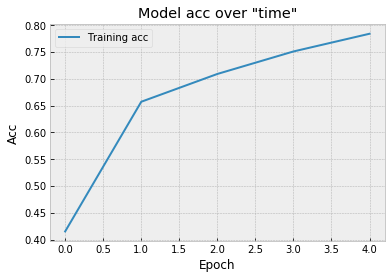

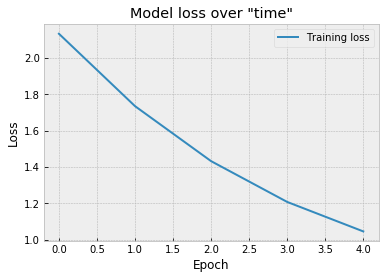

(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

In [8]:
model = build_model(2, units=32)
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE,
                    epochs=EPOCHS, verbose=2)
plot(history)

In [9]:
evaluate(model)

10000/10000 [==============================] - 1s 50us/step


[0.9699308576583863, 0.8028]

This simple neural network achieved ~82% accuracy. We know that MNIST has been solved with 99%+ accuracy, so we can probably do better.

## Task 2

So! Our neural network is kind of awful right now. What would happen if we trained a deepder network? What if we trained it for longer? What if we increased the number of hidden units? What if we changed everything?

This is what we're going to test. Honestly, this is a quite limited network, so its capacity should be reached pretty fast, which means that training it for longer shouldn't help us much.

Similarly, if we kept the number of epochs equal but largely increased the number of parameters, it would most probably have poor performance because it would probably overfit to the training data. Intermediate solutions, though, should have some quite interesting results... Let's find out whether that's the case!

### Case 1: Deep network with same number of nodes

Let's try to increasingly add more layers and see what happens...

Building model with 2 hidden layers:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
 - 2s - loss: 2.2926 - acc: 0.1413
Epoch 2/5
 - 2s - loss: 2.2538 - acc: 0.2527
Epoch 3/5
 - 2s - loss: 2.2197 - acc: 0.3843
Epoch 4/5
 - 2s - loss: 2.1752 - acc: 0.4953
Epoch 5/5
 - 2s - loss: 2.1146 - acc: 0.5397


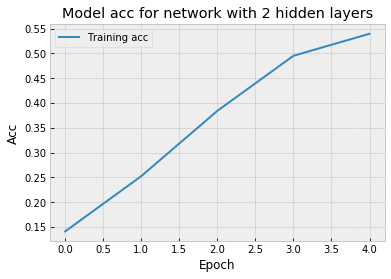

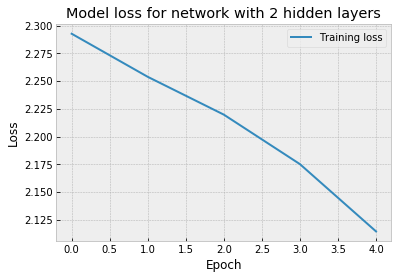

10000/10000 [==============================] - 0s 43us/step
This model had 0.5805 accuracy
Building model with 4 hidden layers:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                330       
Total params: 

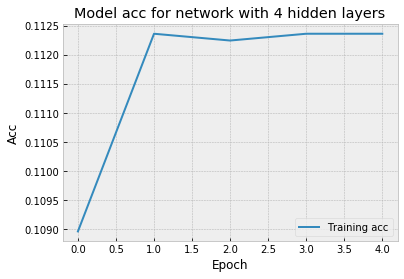

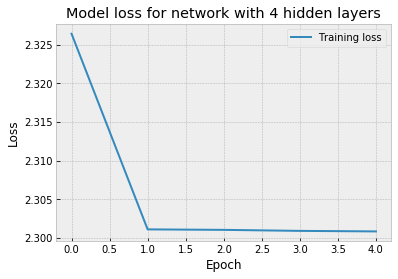

10000/10000 [==============================] - 1s 73us/step
This model had 0.1135 accuracy
Building model with 8 hidden layers:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                1056      
______________

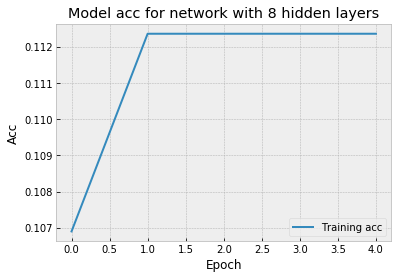

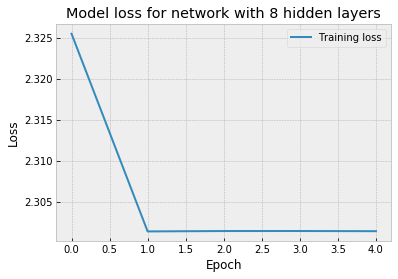

10000/10000 [==============================] - 1s 89us/step
This model had 0.1135 accuracy
Building model with 16 hidden layers:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_21 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_24 (Dense)             (None, 32)                1056      
_____________

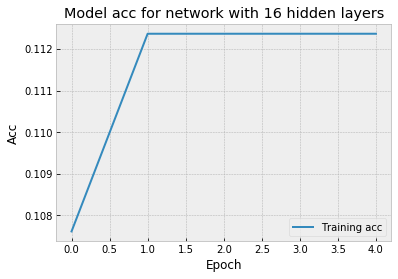

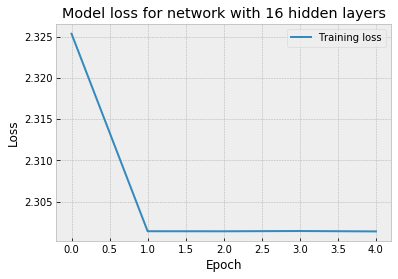

10000/10000 [==============================] - 2s 194us/step
This model had 0.1135 accuracy


In [10]:
for layers in [2, 4, 8, 16]:
    print('Building model with %s hidden layers:' % layers)
    model = build_model(layers + 1, 32)
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE,
                        epochs=EPOCHS, verbose=2)
    plot(history, 'Model %s for network with {} hidden layers'\
                  .format(layers))
    print('This model had %g accuracy' % evaluate(model)[1])

### Analysis

Now this is interesting! Adding more layers makes the network worse! Not only that, but the deeper networks had exactly the same performance! Why?

Well... this is a problem with classic multi-layer perceptrons with sigmoid activations. Gradients are probably vanishing, and parameters stay put, never changing, with the exception of the two hidden layer neural network, which did improve, but it was still worse than the single layer neural net.

Consider, for example the graph of the sigmoid and its derivative:

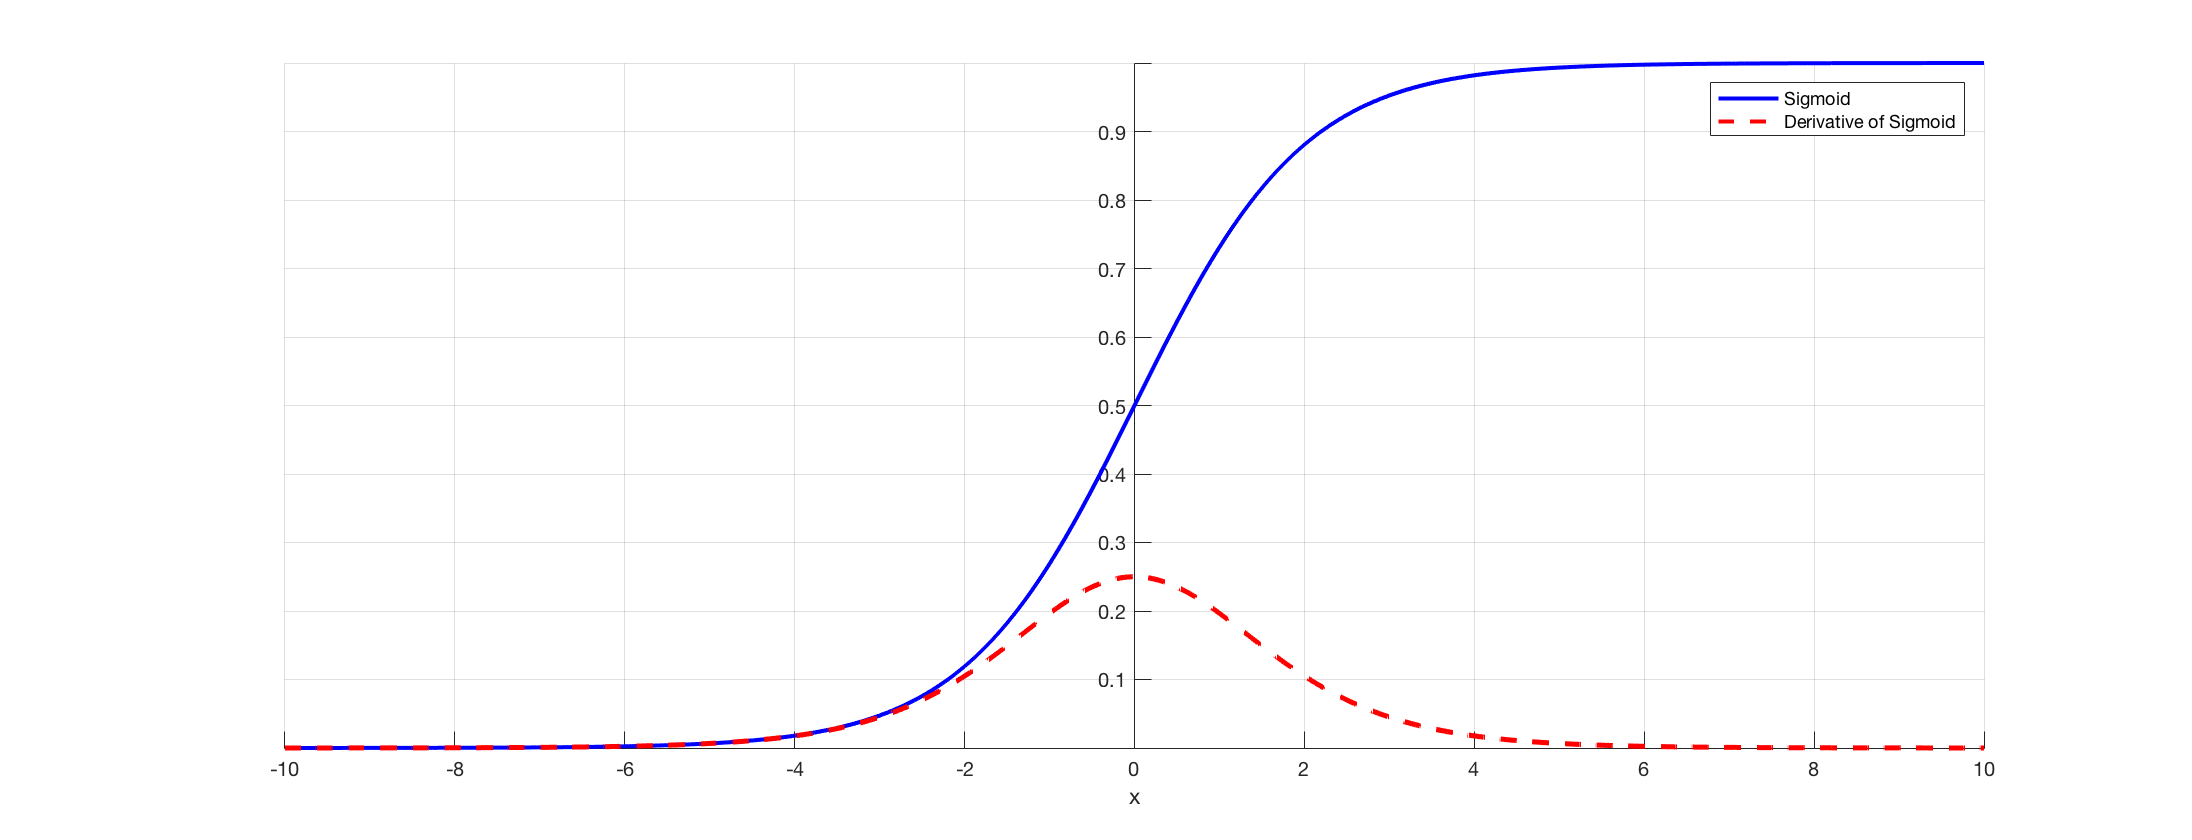

As one can see, the maximum of the derivative of the sigmoid (the point where the second derivative is zero) is at (0, 0.25). Therefore, the deeper the network, the greater the dampening effect of the concatenations of sigmoids. This explains why simply adding more layers isn't the best idea.

### Case 2: Train for longer

As mentioned earlier, we expect that training for longer will exhaust the capacity of our simple two-layer neural network. Beforehand, we can't possibly know how many epochs would be needed, but we should definitely see diminishing returns.

Therefore, training for 100 epochs is most certainly too much. Training from 4 to 5 epochs gave us a ~4% increase, so we should still see good improvement for the next 5-10 epochs. 32 epochs is probably too much as well. Something between 16 and 32 should be our sweet spot.

Let's test this hypothesis by running twice: once with 32, and once with 64 epochs!

Oh! And by the way, this model will probably overfit, so we're going to do a validation split as well...

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_38 (Dense)             (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


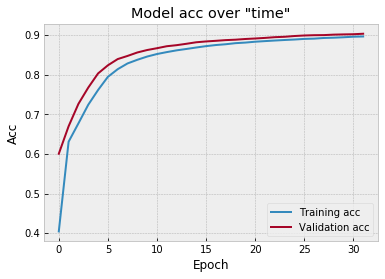

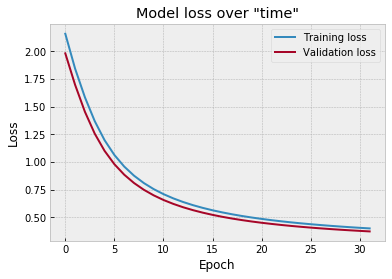

10000/10000 [==============================] - 1s 51us/step
This model had 0.9046 accuracy


In [11]:
model = build_model(2, 32)
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE,
                    epochs=32, verbose=0, validation_split=.2)
plot(history)
print('This model had %g accuracy' % evaluate(model)[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_40 (Dense)             (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


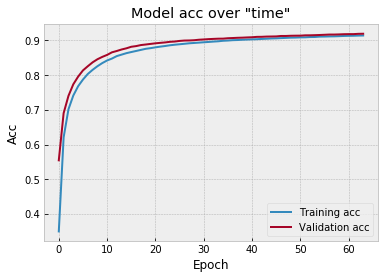

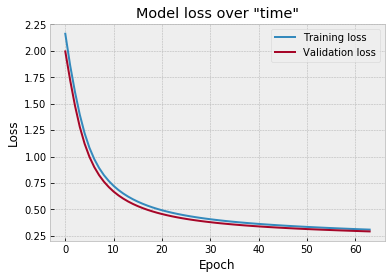

10000/10000 [==============================] - 1s 54us/step
This model had 0.9203 accuracy


In [12]:
model = build_model(2, 32)
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE,
                    epochs=64, verbose=0, validation_split=.2)
plot(history)
print('This model had %g accuracy' % evaluate(model)[1])

### Case 3: A wider network

Now let's try increasing the width of our sincle layer. According to the universal function approximator theorem, we should expect our neural network to (in theory) learn everything there is to learn about MNIST.

Unfortunately, we will hardly solve MNIST with just a single hidden layer. Doing so would probably require a large amount of epochs, since we'll be rapidly increasing the number of parameters of this network. Also, vanilla SGD isn't the best optimization algorithm, so we should expect updates to all parameters to be slow, with many small gradients...

We will also test our hypothesis of how much time it'd take by timing the model fitting process. Time should increase roughly exponentially, due to the rate of increase in hidden units.

Building model with 64 hidden units:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_42 (Dense)             (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
CPU times: user 25.1 s, sys: 5.97 s, total: 31 s
Wall time: 13.2 s


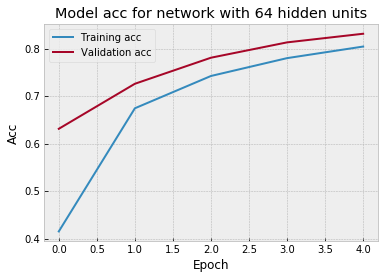

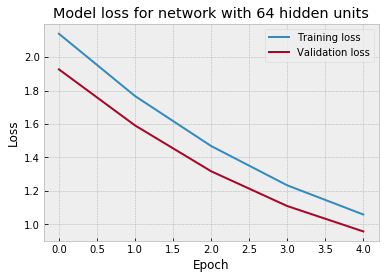

10000/10000 [==============================] - 0s 48us/step
This model had 0.8225 accuracy
Building model with 128 hidden units:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_44 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
CPU times: user 29.7 s, sys: 5.94 s, total: 35.7 s
Wall time: 14.9 s


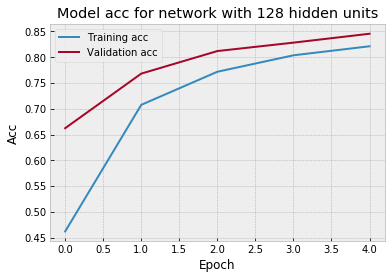

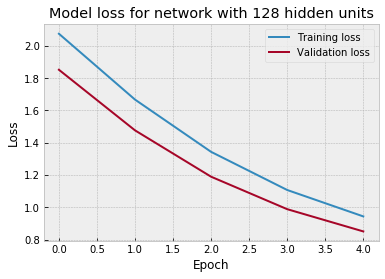

10000/10000 [==============================] - 1s 58us/step
This model had 0.8434 accuracy
Building model with 256 hidden units:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_46 (Dense)             (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
CPU times: user 42.6 s, sys: 5.8 s, total: 48.4 s
Wall time: 19.9 s


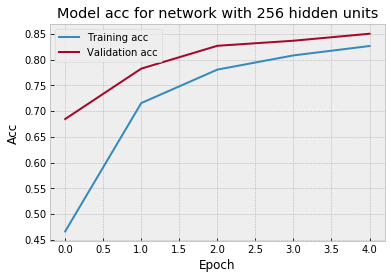

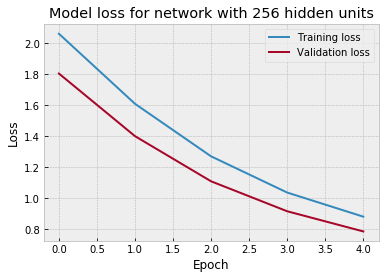

10000/10000 [==============================] - 1s 69us/step
This model had 0.8463 accuracy
Building model with 512 hidden units:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_48 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
CPU times: user 1min 4s, sys: 5.92 s, total: 1min 10s
Wall time: 23.7 s


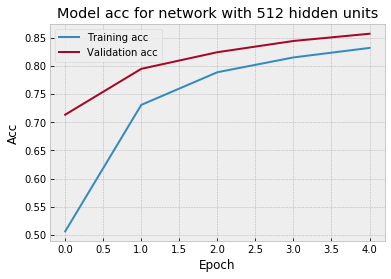

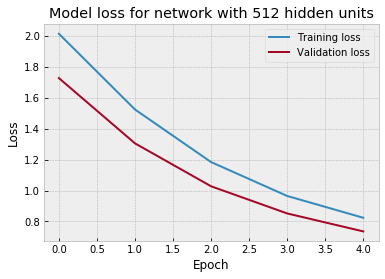

10000/10000 [==============================] - 1s 97us/step
This model had 0.8538 accuracy


In [13]:
for width in [64, 128, 256, 512]:
    print('Building model with %s hidden units:' % width)
    model = build_model(2, width)
    %time history = model.fit(x_train, y_train, batch_size=BATCH_SIZE,\
                              epochs=EPOCHS, verbose=0, \
                              validation_split=.2)
    plot(history, 'Model %s for network with {} hidden units'\
                  .format(width))
    print('This model had %g accuracy' % evaluate(model)[1])

As expected, making the network wider was effective just to a point. After that, perfomance seems to have stagnated in the ~85% accuracy range.

The increase in CPU time wasn't as big as I expected. Let's graph it to see how it went.

Text(0.5, 1.0, 'CPU time to train')

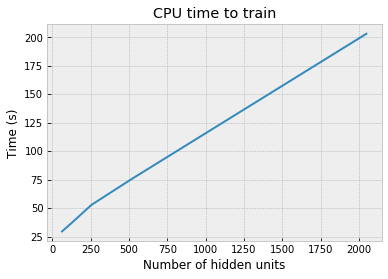

In [14]:
plt.plot(
    [64, 128, 256, 512, 2048],
    [29.5, 37.1, 52.8, 75, 203]
)
plt.xlabel('Number of hidden units')
plt.ylabel('Time (s)')
plt.title('CPU time to train')

Interesting. Time increases linearly. (If you're wondering where the (2048, 203) pair comes from, it comes from the next cell.)

Now we wonder: what if we went overboard and tried something huge, such as a network with 2048 hidden nodes?

Building model with 512 hidden units:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 2048)              1607680   
_________________________________________________________________
dense_50 (Dense)             (None, 10)                20490     
Total params: 1,628,170
Trainable params: 1,628,170
Non-trainable params: 0
_________________________________________________________________
CPU times: user 3min 16s, sys: 5.15 s, total: 3min 21s
Wall time: 50.1 s


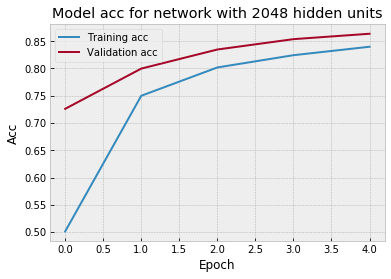

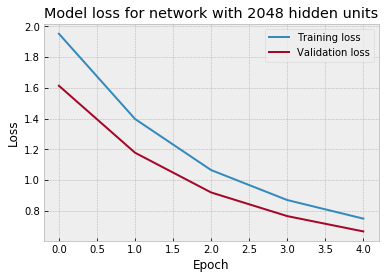

10000/10000 [==============================] - 1s 141us/step
This model had 0.8601 accuracy


In [15]:
print('Building model with %s hidden units:' % 512)
model = build_model(2, 2048)
%time history = model.fit(x_train, y_train, batch_size=BATCH_SIZE,\
                          epochs=EPOCHS, verbose=0,\
                          validation_split=.2)
plot(history, 'Model %s for network with {} hidden units'\
              .format(2048))
print('This model had %g accuracy' % evaluate(model)[1])

As can be seen from the above, time increase is still linear. What about the number of parameters of the hidden layer?

Text(0.5, 1.0, 'Number of parameters as a function of hidden units')

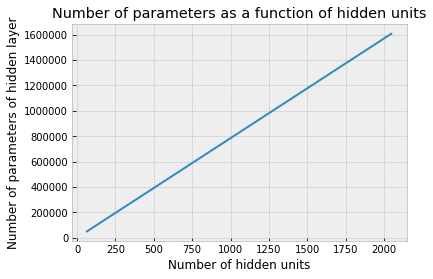

In [16]:
plt.plot(
    [64, 128, 256, 512, 2048],
    [50240, 100480, 200960, 401920, 1607680]
)
plt.xlabel('Number of hidden units')
plt.ylabel('Number of parameters of hidden layer')
plt.title('Number of parameters as a function of hidden units')

Ok! So this makes sense: the number of parameters increases linearly, so the time required to train increases linearly as well.

In retrospect, this is correct, since once the architecture is fixed, time required for training is fixed, as the forward and backward steps are essentially multiplications.

### Case 4: Adding more nodes and more layers

What if we increase two parameters at a time, but kept number of training epochs fixed? This should be fun.

In [17]:
import time
from itertools import product

layers = [2, 4, 8, 16, 32]
widths = [16, 64, 128, 256, 512]

accuracies = np.zeros((len(widths), len(layers)))
times = np.zeros_like(accuracies)
histories = {}

# Helpers indices that allow us to map between values and indices
# in the accuracies and times tables
layers_index = {l: i for l, i in zip(layers, range(len(layers)))}
widths_index = {w: i for w, i in zip(widths, range(len(widths)))}

for w, l in product(widths, layers):
    model = build_model(l, w, print_summary=False)
    start = time.time()
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE,\
                        epochs=EPOCHS, verbose=0, \
                        validation_split=.2)
    end = time.time()
    histories[(w, l)] = history
    accuracies[widths_index[w], layers_index[l]] = evaluate(model)[1]
    times[widths_index[w], layers_index[l]] = end - start

10000/10000 [==============================] - 12s 1ms/step


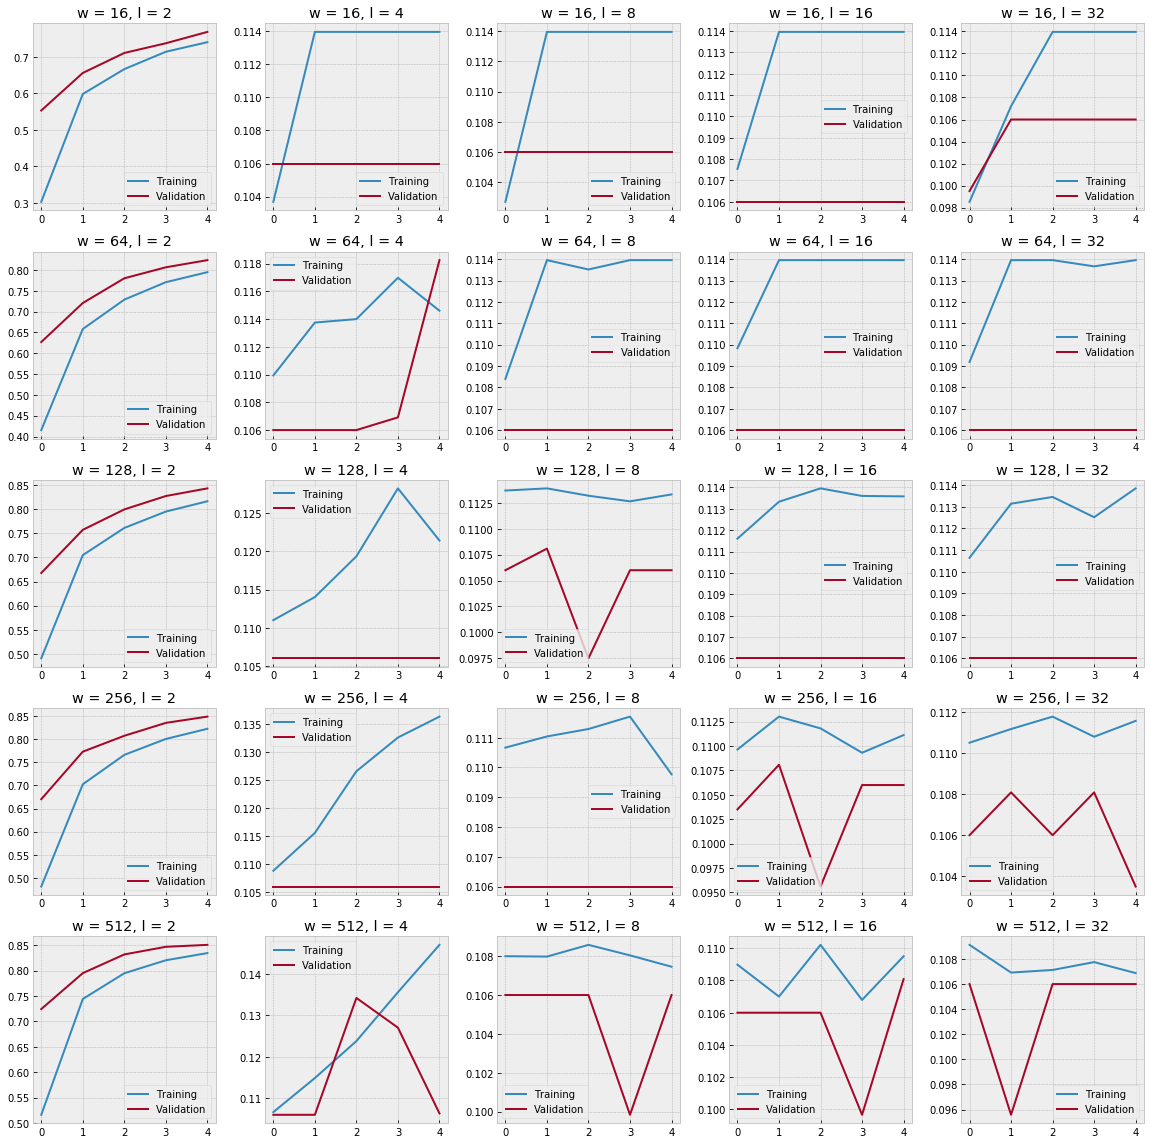

In [18]:
fig = plt.figure(figsize=(16, 16))
plt.title('Model performance for varying layers and units')
plt.xlabel('Accuracy')
for w, l in product(widths, layers):
    key = w, l
    i = widths_index[w]
    j = layers_index[l]
    ax = plt.subplot2grid((len(widths), len(layers)), (i, j))
    ax.plot(histories[key].history['acc'], label='Training')
    ax.plot(histories[key].history['val_acc'], label='Validation')
    ax.set_title('w = {}, l = {}'.format(w, l))
    ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 16))
plt.contourf(widths, layers, accuracies)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Accuracy')
plt.title('Accuracy as a function of layers and units')
plt.xlabel('Hidden layer width')
plt.ylabel('Number of layers')
fig.tight_layout()

In [ ]:
fig = plt.figure(figsize=(16, 16))
plt.contourf(widths, layers, times)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time (s)')
plt.title('Time to train as a function of layers and units')
plt.xlabel('Hidden layer width')
plt.ylabel('Number of layers')
fig.tight_layout()

So this is interesting... Increasing depth of the neural network makes performance tank, while increasing the width of the neural network still works fine. This is, once again, related to the vanishing gradients issue.

In both cases, training time increases, as expected.

## Making it better

So far, our best model achieved ~92% accuracy using a single hidden layer, 32 units, and training for 64 epochs. We expect that we can have higher accuracy by performing hyper parameter optimization. I did some exploration by hand. This is the model I've come up with.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_38 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_361 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_362 (Dense)            (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/128
 - 6s - loss: 2.1204 - acc: 0.4377 - val_loss: 1.8978 - val_acc: 0.6553
Epoch 2/128
 - 3s - loss: 1.7199 - acc: 0.6939 - val_loss: 1.5226 - val_acc: 0.7628
Epoch 3/128
 - 3s - loss: 1.3866 - acc: 0.7637 - val_loss: 1.2218 - val_acc: 0.8106
Epoch 4/128
 - 3s - loss: 1.1348 - acc: 0.8015 - val_loss: 1.0056 - val_acc: 0.8337
Epoch 5/128
 -

Epoch 89/128
 - 3s - loss: 0.2764 - acc: 0.9206 - val_loss: 0.2651 - val_acc: 0.9241
Epoch 90/128
 - 3s - loss: 0.2754 - acc: 0.9209 - val_loss: 0.2646 - val_acc: 0.9242
Epoch 91/128
 - 4s - loss: 0.2746 - acc: 0.9213 - val_loss: 0.2637 - val_acc: 0.9243
Epoch 92/128
 - 3s - loss: 0.2738 - acc: 0.9215 - val_loss: 0.2629 - val_acc: 0.9248
Epoch 93/128
 - 4s - loss: 0.2729 - acc: 0.9217 - val_loss: 0.2622 - val_acc: 0.9246
Epoch 94/128
 - 4s - loss: 0.2720 - acc: 0.9216 - val_loss: 0.2615 - val_acc: 0.9245
Epoch 95/128
 - 4s - loss: 0.2711 - acc: 0.9225 - val_loss: 0.2610 - val_acc: 0.9251
Epoch 96/128
 - 4s - loss: 0.2703 - acc: 0.9226 - val_loss: 0.2602 - val_acc: 0.9253
Epoch 97/128
 - 4s - loss: 0.2695 - acc: 0.9230 - val_loss: 0.2595 - val_acc: 0.9255
Epoch 98/128
 - 4s - loss: 0.2687 - acc: 0.9227 - val_loss: 0.2587 - val_acc: 0.9258
Epoch 99/128
 - 4s - loss: 0.2678 - acc: 0.9233 - val_loss: 0.2582 - val_acc: 0.9259
Epoch 100/128
 - 4s - loss: 0.2670 - acc: 0.9235 - val_loss: 0.25

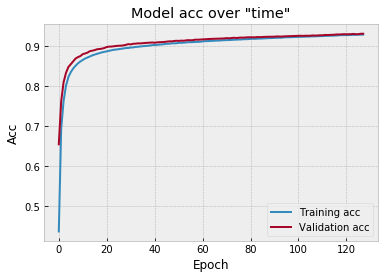

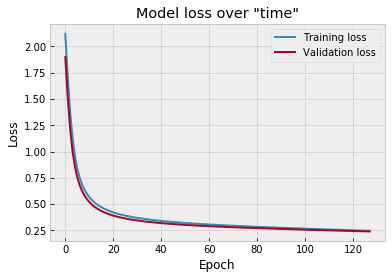

10000/10000 [==============================] - 1s 119us/step
This model had 0.9315 accuracy


In [21]:
model = build_model(2, 128)
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE,
                    epochs=128, verbose=2, validation_split=.2)
plot(history)
print('This model had %g accuracy' % evaluate(model)[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_39 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_363 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_364 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_365 (Dense)            (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/128
 - 7s - loss: 2.3087 - acc: 0.1376 - val_loss: 2.2677 - val_acc: 0.1502
Epoch 2/128
 - 4s - loss: 2.2477 - acc: 0.2534 - val_loss: 2.2254 - val_acc: 0.3658
Epoch 3/128
 - 4s - loss: 2.2025 - acc: 0.3913 - v

Epoch 87/128
 - 3s - loss: 0.3000 - acc: 0.9136 - val_loss: 0.2867 - val_acc: 0.9195
Epoch 88/128
 - 3s - loss: 0.2987 - acc: 0.9140 - val_loss: 0.2858 - val_acc: 0.9200
Epoch 89/128
 - 3s - loss: 0.2975 - acc: 0.9140 - val_loss: 0.2845 - val_acc: 0.9201
Epoch 90/128
 - 3s - loss: 0.2963 - acc: 0.9147 - val_loss: 0.2835 - val_acc: 0.9206
Epoch 91/128
 - 3s - loss: 0.2951 - acc: 0.9152 - val_loss: 0.2824 - val_acc: 0.9197
Epoch 92/128
 - 3s - loss: 0.2939 - acc: 0.9153 - val_loss: 0.2813 - val_acc: 0.9201
Epoch 93/128
 - 3s - loss: 0.2927 - acc: 0.9160 - val_loss: 0.2805 - val_acc: 0.9210
Epoch 94/128
 - 3s - loss: 0.2916 - acc: 0.9160 - val_loss: 0.2793 - val_acc: 0.9209
Epoch 95/128
 - 3s - loss: 0.2905 - acc: 0.9164 - val_loss: 0.2783 - val_acc: 0.9213
Epoch 96/128
 - 3s - loss: 0.2894 - acc: 0.9167 - val_loss: 0.2773 - val_acc: 0.9213
Epoch 97/128
 - 3s - loss: 0.2882 - acc: 0.9170 - val_loss: 0.2765 - val_acc: 0.9216
Epoch 98/128
 - 3s - loss: 0.2871 - acc: 0.9172 - val_loss: 0.275

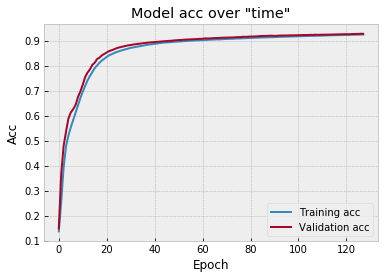

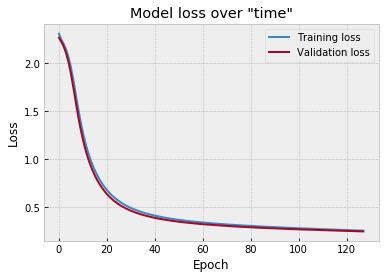

10000/10000 [==============================] - 1s 93us/step
This model had 0.926 accuracy


In [22]:
model = build_model(3, [128, 64])
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE,
                    epochs=128, verbose=2, validation_split=.2)
plot(history)
print('This model had %g accuracy' % evaluate(model)[1])

## Task 4

Now we are free to change whatever parameter we like. We should probably change from sigmoids to ReLUs, to prevent the vanishing gradients. That should help us improve our model.


Train on 48000 samples, validate on 12000 samples
Epoch 1/16
 - 21s - loss: 1.1730 - acc: 0.6009 - val_loss: 0.3274 - val_acc: 0.9173
Epoch 2/16
 - 12s - loss: 0.6329 - acc: 0.8165 - val_loss: 0.2103 - val_acc: 0.9437
Epoch 3/16
 - 12s - loss: 0.4984 - acc: 0.8642 - val_loss: 0.1767 - val_acc: 0.9523
Epoch 4/16
 - 11s - loss: 0.4272 - acc: 0.8867 - val_loss: 0.1549 - val_acc: 0.9573
Epoch 5/16
 - 11s - loss: 0.3826 - acc: 0.8999 - val_loss: 0.1426 - val_acc: 0.9615
Epoch 6/16
 - 11s - loss: 0.3540 - acc: 0.9072 - val_loss: 0.1408 - val_acc: 0.9630
Epoch 7/16
 - 11s - loss: 0.3276 - acc: 0.9138 - val_loss: 0.1380 - val_acc: 0.9634
Epoch 8/16
 - 11s - loss: 0.3161 - acc: 0.9174 - val_loss: 0.1266 - val_acc: 0.9641
Epoch 9/16
 - 11s - loss: 0.3002 - acc: 0.9230 - val_loss: 0.1139 - val_acc: 0.9685
Epoch 10/16
 - 11s - loss: 0.2875 - acc: 0.9264 - val_loss: 0.1230 - val_acc: 0.9651
Epoch 11/16
 - 11s - loss: 0.2823 - acc: 0.9263 - val_loss: 0.1121 - val_acc: 0.9700
Epoch 12/16
 - 11s - los

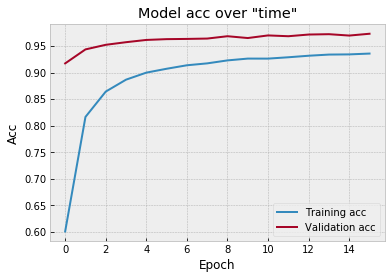

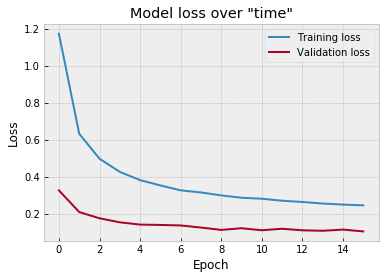

10000/10000 [==============================] - 1s 132us/step
This model had 0.9721 accuracy


In [65]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(HEIGHT, WIDTH)))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer='adam')
history = model.fit(x_train, y_train, batch_size=64,
                    epochs=16, verbose=2, validation_split=.2)
plot(history)
print('This model had %g accuracy' % evaluate(model)[1])

# Extra credit

We've found a pretty decent network. But, what if the training data is incorrect? How good can our network be? Should performance of the best network drop by 10%? Can the network learn to ignore those labels?

## Noisy labels

In [24]:
def build_noisy_dataset(x_train, y_train, corruption_amount=0.11,
                        verbose=True):
    y_train = np.copy(y_train)  # to make sure we don't corrupt the orig
    shuffle_amount = int(corruption_amount * len(y_train))
    shuffle_start = np.random.randint(0, len(y_train) - shuffle_amount)
    shuffle_end = shuffle_start + shuffle_amount
    new_labels = np.random.randint(0, CLASSES, size=shuffle_amount)
    y_train[shuffle_start:shuffle_end] = keras.utils.to_categorical(
        new_labels, CLASSES
    )
    if verbose:
        fig, ax = plt.subplots(1, 3)
        for i in range(3):
            ax[i].imshow(x_train[shuffle_start + i],
                         cmap='gray', interpolation='bilinear')
            ax[i].set_title('Label: ' + str(np.argmax(
                y_train[shuffle_start + i]
            )))
    return y_train

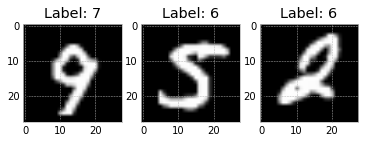

In [61]:
noisy_y_train = build_noisy_dataset(x_train, y_train)

Train on 48000 samples, validate on 12000 samples
Epoch 1/16
 - 12s - loss: 1.4445 - acc: 0.5951 - val_loss: 0.4336 - val_acc: 0.9291
Epoch 2/16
 - 8s - loss: 1.1361 - acc: 0.7582 - val_loss: 0.3645 - val_acc: 0.9499
Epoch 3/16
 - 8s - loss: 1.0546 - acc: 0.7889 - val_loss: 0.3014 - val_acc: 0.9587
Epoch 4/16
 - 8s - loss: 1.0097 - acc: 0.8030 - val_loss: 0.2730 - val_acc: 0.9630
Epoch 5/16
 - 7s - loss: 0.9767 - acc: 0.8139 - val_loss: 0.2842 - val_acc: 0.9637
Epoch 6/16
 - 8s - loss: 0.9448 - acc: 0.8221 - val_loss: 0.2414 - val_acc: 0.9668
Epoch 7/16
 - 8s - loss: 0.9262 - acc: 0.8249 - val_loss: 0.2400 - val_acc: 0.9658
Epoch 8/16
 - 8s - loss: 0.9140 - acc: 0.8283 - val_loss: 0.2350 - val_acc: 0.9676
Epoch 9/16
 - 8s - loss: 0.8948 - acc: 0.8318 - val_loss: 0.2199 - val_acc: 0.9680
Epoch 10/16
 - 8s - loss: 0.8787 - acc: 0.8322 - val_loss: 0.2214 - val_acc: 0.9649
Epoch 11/16
 - 8s - loss: 0.8731 - acc: 0.8349 - val_loss: 0.2111 - val_acc: 0.9692
Epoch 12/16
 - 8s - loss: 0.8589 -

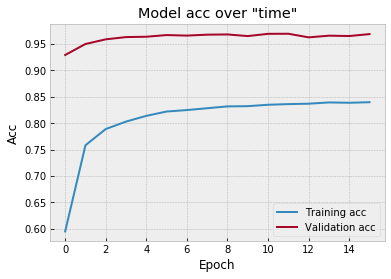

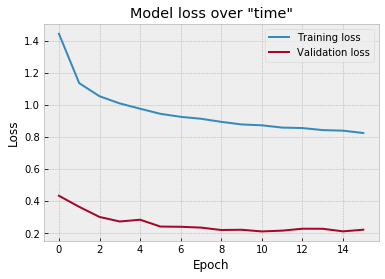

10000/10000 [==============================] - 1s 99us/step
This model had 0.9687 accuracy


In [26]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(HEIGHT, WIDTH)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer='adam')
history = model.fit(x_train, noisy_y_train, batch_size=64,
                    epochs=16, verbose=2, validation_split=.2)
plot(history)
print('This model had %g accuracy' % evaluate(model)[1])

It appears our architecture above is already robust to the noise, as performance decreased only by a little. This is probably due to the use of dropout. The random deactivation of units with dropout essentially gives us an ensemble of networks for the price of one.

With this ensemble, the network is probably learning to "ignore" the entries with wrong labels.

More surprising is that validation accuracy and loss are much better than its training counterpart, which is odd.

## Obscured images

Ok. So we didn't have to change our architecture to achieve robust results with noisy labels. What if we obscure our images?

In [27]:
def obscure_images(x, y, corruption_shape=(14, 14),
                   verbose=True):
    x = np.copy(x)  # to make sure we don't corrupt the orig
    mask = np.zeros(corruption_shape)
    for idx in range(x.shape[0]):
        i = np.random.randint(0, x.shape[1] - corruption_shape[0])
        j = np.random.randint(0, x.shape[2] - corruption_shape[1])
        x[idx, i:i+corruption_shape[0], j:j+corruption_shape[1]] = mask
    if verbose:
        fig, ax = plt.subplots(1, 3)
        for i in range(3):
            ax[i].imshow(x[i], cmap='gray', interpolation='bilinear')
            ax[i].set_title('Label: ' + str(np.argmax(
                y[i]
            )))
    return x

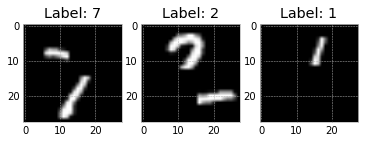

In [28]:
x_test_obscured = obscure_images(x_test, y_test)

In [29]:
evaluate(model, x_test=x_test_obscured)

10000/10000 [==============================] - 1s 108us/step


[1.7663560688018798, 0.4699]

Notice this is our model that was trained to be robust to noise. Its performance dropped from ~97+% to ~51%. Let's try to build a better one...

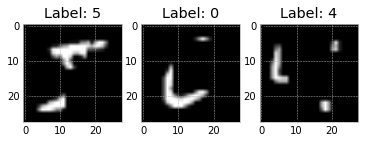

In [30]:
x_train_obscured = obscure_images(x_train, y_train)

First, let's try reusing the model we already have. Notice that by reusing the model, we're essentially taking a pre-trained model and presenting new examples to it. So we can leverage what the model had already learned about the original dataset.

Train on 48000 samples, validate on 12000 samples
Epoch 1/16
 - 7s - loss: 0.8554 - acc: 0.7529 - val_loss: 0.4997 - val_acc: 0.8489
Epoch 2/16
 - 7s - loss: 0.6375 - acc: 0.8193 - val_loss: 0.4672 - val_acc: 0.8576
Epoch 3/16
 - 7s - loss: 0.5734 - acc: 0.8379 - val_loss: 0.4382 - val_acc: 0.8661
Epoch 4/16
 - 8s - loss: 0.5337 - acc: 0.8479 - val_loss: 0.4283 - val_acc: 0.8712
Epoch 5/16
 - 8s - loss: 0.5081 - acc: 0.8561 - val_loss: 0.4235 - val_acc: 0.8738
Epoch 6/16
 - 7s - loss: 0.4854 - acc: 0.8632 - val_loss: 0.4277 - val_acc: 0.8741
Epoch 7/16
 - 8s - loss: 0.4521 - acc: 0.8701 - val_loss: 0.4375 - val_acc: 0.8726
Epoch 8/16
 - 8s - loss: 0.4429 - acc: 0.8726 - val_loss: 0.4273 - val_acc: 0.8717
Epoch 9/16
 - 8s - loss: 0.4250 - acc: 0.8785 - val_loss: 0.4375 - val_acc: 0.8789
Epoch 10/16
 - 8s - loss: 0.4081 - acc: 0.8835 - val_loss: 0.4498 - val_acc: 0.8749
Epoch 11/16
 - 8s - loss: 0.3925 - acc: 0.8859 - val_loss: 0.4636 - val_acc: 0.8728
Epoch 12/16
 - 8s - loss: 0.3778 - 

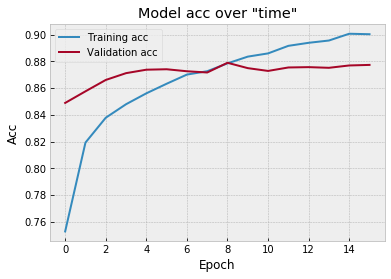

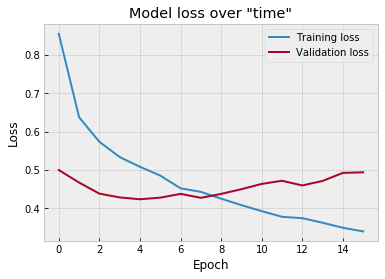

(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

In [31]:
history = model.fit(x_train_obscured, y_train, batch_size=64,
                    epochs=16, verbose=2, validation_split=.2)
plot(history)

Our model now seems to be overfitting to the training set. Let's see how it fares on the test set. Then, perhaps we should reduce its capacity...

In [32]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(HEIGHT, WIDTH)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer='adam')

Train on 48000 samples, validate on 12000 samples
Epoch 1/64
 - 11s - loss: 1.3510 - acc: 0.5475 - val_loss: 0.7097 - val_acc: 0.7869
Epoch 2/64
 - 8s - loss: 0.9491 - acc: 0.6996 - val_loss: 0.5953 - val_acc: 0.8123
Epoch 3/64
 - 8s - loss: 0.8516 - acc: 0.7370 - val_loss: 0.5610 - val_acc: 0.8269
Epoch 4/64
 - 8s - loss: 0.7971 - acc: 0.7554 - val_loss: 0.5276 - val_acc: 0.8342
Epoch 5/64
 - 8s - loss: 0.7606 - acc: 0.7654 - val_loss: 0.5078 - val_acc: 0.8420
Epoch 6/64
 - 8s - loss: 0.7341 - acc: 0.7744 - val_loss: 0.4908 - val_acc: 0.8459
Epoch 7/64
 - 8s - loss: 0.7109 - acc: 0.7822 - val_loss: 0.4880 - val_acc: 0.8475
Epoch 8/64
 - 7s - loss: 0.6943 - acc: 0.7891 - val_loss: 0.4747 - val_acc: 0.8494
Epoch 9/64
 - 8s - loss: 0.6801 - acc: 0.7919 - val_loss: 0.4685 - val_acc: 0.8534
Epoch 10/64
 - 9s - loss: 0.6670 - acc: 0.7953 - val_loss: 0.4645 - val_acc: 0.8560
Epoch 11/64
 - 8s - loss: 0.6497 - acc: 0.7999 - val_loss: 0.4626 - val_acc: 0.8572
Epoch 12/64
 - 8s - loss: 0.6463 -

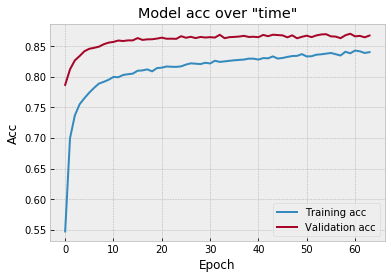

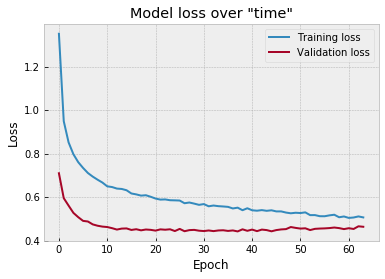

(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

In [33]:
history = model.fit(x_train_obscured, y_train, batch_size=64,
                    epochs=64, verbose=2, validation_split=.2)
plot(history)

In [34]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(HEIGHT, WIDTH)))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer='adam')

Train on 48000 samples, validate on 12000 samples
Epoch 1/64
 - 8s - loss: 1.3372 - acc: 0.5556 - val_loss: 0.8354 - val_acc: 0.7586
Epoch 2/64
 - 5s - loss: 1.0424 - acc: 0.6584 - val_loss: 0.7398 - val_acc: 0.7762
Epoch 3/64
 - 5s - loss: 0.9745 - acc: 0.6793 - val_loss: 0.7000 - val_acc: 0.7825
Epoch 4/64
 - 5s - loss: 0.9500 - acc: 0.6833 - val_loss: 0.6753 - val_acc: 0.7867
Epoch 5/64
 - 5s - loss: 0.9257 - acc: 0.6899 - val_loss: 0.6547 - val_acc: 0.7935
Epoch 6/64
 - 5s - loss: 0.9005 - acc: 0.6960 - val_loss: 0.6419 - val_acc: 0.7963
Epoch 7/64
 - 6s - loss: 0.8937 - acc: 0.6999 - val_loss: 0.6347 - val_acc: 0.7956
Epoch 8/64
 - 5s - loss: 0.8885 - acc: 0.6999 - val_loss: 0.6254 - val_acc: 0.8004
Epoch 9/64
 - 5s - loss: 0.8792 - acc: 0.7021 - val_loss: 0.6220 - val_acc: 0.8020
Epoch 10/64
 - 5s - loss: 0.8749 - acc: 0.7049 - val_loss: 0.6115 - val_acc: 0.8030
Epoch 11/64
 - 5s - loss: 0.8653 - acc: 0.7076 - val_loss: 0.6109 - val_acc: 0.8049
Epoch 12/64
 - 5s - loss: 0.8598 - 

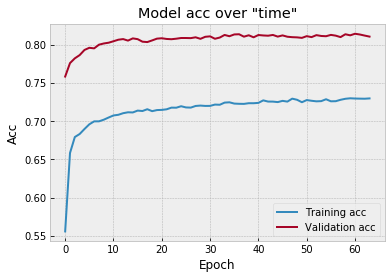

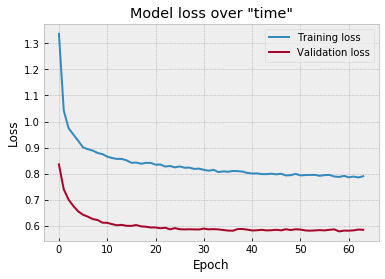

(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

In [35]:
history = model.fit(x_train_obscured, y_train, batch_size=64,
                    epochs=64, verbose=2, validation_split=.2)
plot(history)

In [36]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(HEIGHT, WIDTH)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer='adam')

In [37]:
history = model.fit(x_train_obscured, y_train, batch_size=64,
                    epochs=64, verbose=2, validation_split=.2)
plot(history)

Train on 48000 samples, validate on 12000 samples
Epoch 1/64
 - 12s - loss: 1.4325 - acc: 0.5034 - val_loss: 0.7866 - val_acc: 0.7604
Epoch 2/64
 - 7s - loss: 1.0011 - acc: 0.6651 - val_loss: 0.6561 - val_acc: 0.7979
Epoch 3/64
 - 7s - loss: 0.9014 - acc: 0.7078 - val_loss: 0.6013 - val_acc: 0.8154
Epoch 4/64
 - 8s - loss: 0.8486 - acc: 0.7294 - val_loss: 0.5641 - val_acc: 0.8243
Epoch 5/64
 - 8s - loss: 0.7972 - acc: 0.7454 - val_loss: 0.5405 - val_acc: 0.8328
Epoch 6/64
 - 8s - loss: 0.7698 - acc: 0.7530 - val_loss: 0.5361 - val_acc: 0.8332
Epoch 7/64
 - 8s - loss: 0.7395 - acc: 0.7643 - val_loss: 0.5212 - val_acc: 0.8392
Epoch 8/64
 - 8s - loss: 0.7324 - acc: 0.7663 - val_loss: 0.5036 - val_acc: 0.8434
Epoch 9/64
 - 8s - loss: 0.7088 - acc: 0.7737 - val_loss: 0.5112 - val_acc: 0.8387
Epoch 10/64
 - 8s - loss: 0.7004 - acc: 0.7795 - val_loss: 0.5004 - val_acc: 0.8457
Epoch 11/64
 - 8s - loss: 0.6857 - acc: 0.7831 - val_loss: 0.4943 - val_acc: 0.8486
Epoch 12/64
 - 8s - loss: 0.6732 -

KeyboardInterrupt: 

In [38]:
evaluate(model, x_test=x_test_obscured)

10000/10000 [==============================] - 1s 103us/step


[0.4752877441883087, 0.8553]

I've tried a few different architectures, but I can't seem to find a neural net that goes north of 87% of accuracy. I think I will try another problem...

## Different costs of misclassification

So now we want to boost our predictor's ability to classify eights. To do that, we probably want to assess how well it fares on only eights.

Then, we can train a model that specializes on classifying eights (for example, by increasing the sample weights of eights) so that we can check the model's performance overall and with eights.

In [39]:
def split_eights(x, y, verbose=True):
    x = np.copy(x)
    y = np.copy(y)
    labels = np.argmax(y, axis=1)
    x_eights = x[labels == 8]
    y_eights = y[labels == 8]
    x_not_eights = x[labels != 8]
    y_not_eights = y[labels != 8]
    if verbose:
        fig, ax = plt.subplots(1, 3)
        for i in range(3):
            ax[i].imshow(x_eights[i], cmap='gray')
            ax[i].set_title(str(np.argmax(y_eights[i])))
        fig.show()
        fig, ax = plt.subplots(1, 3)
        for i in range(3):
            ax[i].imshow(x_not_eights[i], cmap='gray')
            ax[i].set_title(str(np.argmax(y_not_eights[i])))
        fig.show()
    return x_eights, y_eights, x_not_eights, y_not_eights

### Training set split between eights and not eights

/Users/renatoc/Applications/miniconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
/Users/renatoc/Applications/miniconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


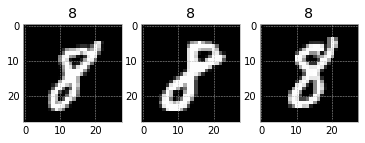

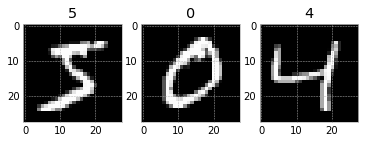

In [40]:
x_train_eights, y_train_eights, x_train_not_eights, y_train_not_eights =\
    split_eights(x_train, y_train)

### Test set split between eights and not eights

/Users/renatoc/Applications/miniconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
/Users/renatoc/Applications/miniconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


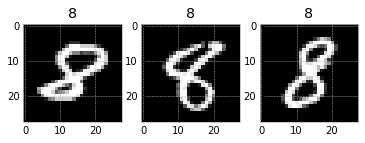

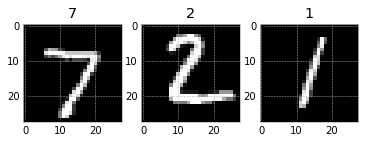

In [41]:
x_test_eights, y_test_eights, x_test_not_eights, y_test_not_eights =\
    split_eights(x_test, y_test)

Now we can train a model using the original dataset and see how it fares in the eight/non-eight dataset. With this, we will have a baseline upon which we can work on. Let's build our best model so far and work from there!

In [52]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(HEIGHT, WIDTH)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer='adam')

Train on 48000 samples, validate on 12000 samples
Epoch 1/16
 - 13s - loss: 0.9997 - acc: 0.6659 - val_loss: 0.2922 - val_acc: 0.9203
Epoch 2/16
 - 8s - loss: 0.5134 - acc: 0.8473 - val_loss: 0.2208 - val_acc: 0.9387
Epoch 3/16
 - 9s - loss: 0.4165 - acc: 0.8800 - val_loss: 0.1829 - val_acc: 0.9517
Epoch 4/16
 - 8s - loss: 0.3719 - acc: 0.8935 - val_loss: 0.1727 - val_acc: 0.9533
Epoch 5/16
 - 9s - loss: 0.3324 - acc: 0.9036 - val_loss: 0.1517 - val_acc: 0.9593
Epoch 6/16
 - 8s - loss: 0.3126 - acc: 0.9122 - val_loss: 0.1533 - val_acc: 0.9597
Epoch 7/16
 - 8s - loss: 0.2952 - acc: 0.9156 - val_loss: 0.1455 - val_acc: 0.9617
Epoch 8/16
 - 8s - loss: 0.2840 - acc: 0.9191 - val_loss: 0.1390 - val_acc: 0.9649
Epoch 9/16
 - 7s - loss: 0.2676 - acc: 0.9241 - val_loss: 0.1383 - val_acc: 0.9627
Epoch 10/16
 - 8s - loss: 0.2535 - acc: 0.9265 - val_loss: 0.1417 - val_acc: 0.9655
Epoch 11/16
 - 8s - loss: 0.2490 - acc: 0.9297 - val_loss: 0.1302 - val_acc: 0.9683
Epoch 12/16
 - 8s - loss: 0.2405 -

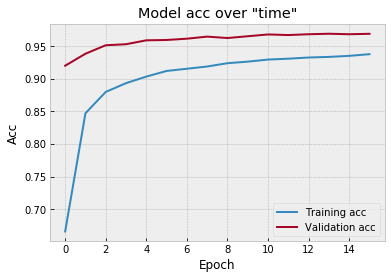

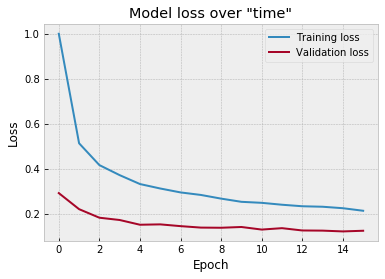

(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

In [53]:
history = model.fit(x_train, y_train, batch_size=64,
                    epochs=16, verbose=2, validation_split=.2)
plot(history)

Now, how does this model fare with separate classes?

In [54]:
print('Model accuracy with eights only',
    evaluate(model, x_test=x_test_eights, y_test=y_test_eights)[1]
)
print('Model accuracy without eights',
    evaluate(model, x_test=x_test_not_eights, y_test=y_test_not_eights)[1]
)

974/974 [==============================] - 0s 184us/step
Model accuracy with eights only 0.9579055437806695
9026/9026 [==============================] - 1s 117us/step
Model accuracy without eights 0.9685353423443386


In [45]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(HEIGHT, WIDTH)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer='adam')

Train on 48000 samples, validate on 12000 samples
Epoch 1/16
 - 11s - loss: 1.8406 - acc: 0.5196 - val_loss: 0.5273 - val_acc: 0.8493
Epoch 2/16
 - 7s - loss: 0.8805 - acc: 0.7730 - val_loss: 0.3481 - val_acc: 0.9038
Epoch 3/16
 - 8s - loss: 0.6980 - acc: 0.8249 - val_loss: 0.2805 - val_acc: 0.9223
Epoch 4/16
 - 8s - loss: 0.6063 - acc: 0.8472 - val_loss: 0.2526 - val_acc: 0.9288
Epoch 5/16
 - 8s - loss: 0.5434 - acc: 0.8639 - val_loss: 0.2269 - val_acc: 0.9374
Epoch 6/16
 - 8s - loss: 0.5326 - acc: 0.8669 - val_loss: 0.2107 - val_acc: 0.9427
Epoch 7/16
 - 8s - loss: 0.4675 - acc: 0.8816 - val_loss: 0.1959 - val_acc: 0.9479
Epoch 8/16
 - 8s - loss: 0.4502 - acc: 0.8861 - val_loss: 0.2063 - val_acc: 0.9462
Epoch 9/16
 - 9s - loss: 0.4360 - acc: 0.8888 - val_loss: 0.1874 - val_acc: 0.9503
Epoch 10/16
 - 8s - loss: 0.4192 - acc: 0.8941 - val_loss: 0.1991 - val_acc: 0.9469
Epoch 11/16
 - 8s - loss: 0.3974 - acc: 0.8994 - val_loss: 0.1866 - val_acc: 0.9515
Epoch 12/16
 - 8s - loss: 0.3790 -

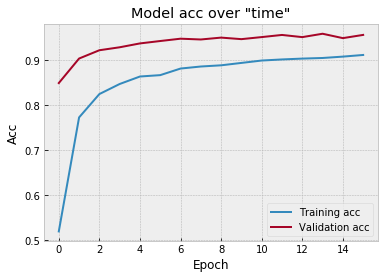

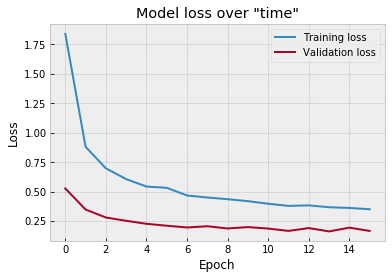

(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

In [48]:
x = np.vstack((x_train_eights, x_train_not_eights))
y = np.vstack((y_train_eights, y_train_not_eights))
weights = [10] * len(x_train_eights) + [1] * len(x_train_not_eights)
history = model.fit(x, y, batch_size=64,
                    epochs=16, verbose=2, validation_split=.2,
                    sample_weight=np.array(weights))
plot(history)

In [51]:
print('Model accuracy with eights only',
    evaluate(model, x_test=x_test_eights, y_test=y_test_eights)[1]
)
print('Model accuracy without eights',
    evaluate(model, x_test=x_test_not_eights, y_test=y_test_not_eights)[1]
)

974/974 [==============================] - 0s 149us/step
Model accuracy with eights only 0.9825462012320328
9026/9026 [==============================] - 1s 115us/step
Model accuracy without eights 0.9526922224684246


In [55]:
0.9685353423443386-0.9526922224684246

0.015843119875914025